In [41]:
import os
import glob
from datetime import datetime
from concurrent import futures

import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web

import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl

import seaborn as sns
import matplotlib.pyplot as plt


List of S & P stocks could be read from its Wiki page.

In [2]:
def get_s_and_p_list():
    """ list of s_anp_p companies 
    
    input: url of the Wikipedia page to get list of stocks"""
        
    # get updated list of s_and_p stocks
    # Ignore SSL certificate errors for https
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

    try:
        html = urllib.request.urlopen(url, context=ctx).read()
    except:
        print("*** Error in retrieval")

    soup = BeautifulSoup(html, 'html.parser')

    table = soup.find('table')
    df_spy = pd.read_html(str(table), header = 0)[0]
    return list(df_spy.Symbol)

Each stock daily trends can be doanloaded rom the below link.

In [3]:
# download a specific stock data
# and save each stock in a seperate .csv file

def download_stock(stock):
    """ try to query the iex for a stock, if failed note with print """
    try:
        stock_df = web.DataReader(stock,'yahoo', start_time, now_time)
        stock_df['Name'] = stock
        output_name = 'stocks_data/{}_data.csv'.format(stock) #stock + '_data.csv'
        stock_df.to_csv(output_name)        
#         all_stocks = pd.concat(all_stocks, stock_df)
    except:
        bad_names.append(stock)
        print('bad: %s' % (stock))

In [4]:
if __name__ == '__main__':

    """ set the download window """
    now_time = datetime.now()
    start_time = datetime(now_time.year - 5, now_time.month , now_time.day)
    all_stocks = pd.DataFrame()
    s_and_p = get_s_and_p_list()  
    # removing dot form stock name to prevent bad_name errors
    s_and_p = [x.replace(".","") for x in s_and_p]
    
    bad_names =[] #to keep track of failed queries

    """here we use the concurrent.futures module's ThreadPoolExecutor
        to speed up the downloads buy doing them in parallel 
        as opposed to sequentially """

    #set the maximum thread number
    max_workers = 50

    workers = min(max_workers, len(s_and_p)) #in case a smaller number of stocks than threads was passed in
    with futures.ThreadPoolExecutor(workers) as executor:
        res = executor.map(download_stock, s_and_p)


    """ Save failed queries to a text file to retry """
    if len(bad_names) > 0:
        with open('failed_queries.txt','w') as outfile:
            for name in bad_names:
                outfile.write(name+'\n')

    #timing:
    finish_time = datetime.now()
    duration = finish_time - now_time
    minutes, seconds = divmod(duration.seconds, 60)
    print('getSandP_threaded.py')
    print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
    #The threaded script took 0 minutes and 31 seconds to run.

bad: BRKB
bad: BFB
getSandP_threaded.py
The threaded script took 1 minutes and 9 seconds to run.


In [5]:
# Merge  all csv files to one for all stocks
# chaging directory to merge csv files
owd = os.getcwd()
os.chdir("stocks_data/")

extension = 'csv'
output_filename = "all_s_and_p_data.csv"
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
if output_filename in all_filenames: all_filenames.remove(output_filename)
# all_filenames
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv(output_filename, index=False)#, encoding='utf-8-sig')
# retruning to previous direcotry
os.chdir(owd)
s_and_p_data = pd.read_csv('stocks_data/all_s_and_p_data.csv', parse_dates = ['Date'], index_col = 'Date')

__Comaping 4 major tech stocks__

In [13]:
major_tech = ['AAPL', 'GOOG', 'MSFT', 'AMZN'] 
# df_compare = pd.DataFrame(columns = major_tech)
df_compare = pd.DataFrame()
for name in major_tech:
    df_compare[name] = s_and_p_data[s_and_p_data.Name == name]['Adj Close']#.pct_change()
df_compare_change = df_compare.pct_change().dropna()

In [14]:
df_compare_change.head()

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2016-03-02,0.002188,0.000056,0.007037,0.002021
2016-03-03,0.007444,-0.008945,-0.011331,-0.004688
2016-03-04,0.014877,-0.002148,-0.006113,-0.004069
2016-03-07,-0.011067,-0.022127,-0.019220,-0.021456
2016-03-08,-0.008246,-0.001712,0.012150,-0.004513


These stocks are highly correlated as they are in teh same area. Finding correlation between these stocks and other stoks and using deep learning algorithm might be able to predict other stocks from these or vise versa.

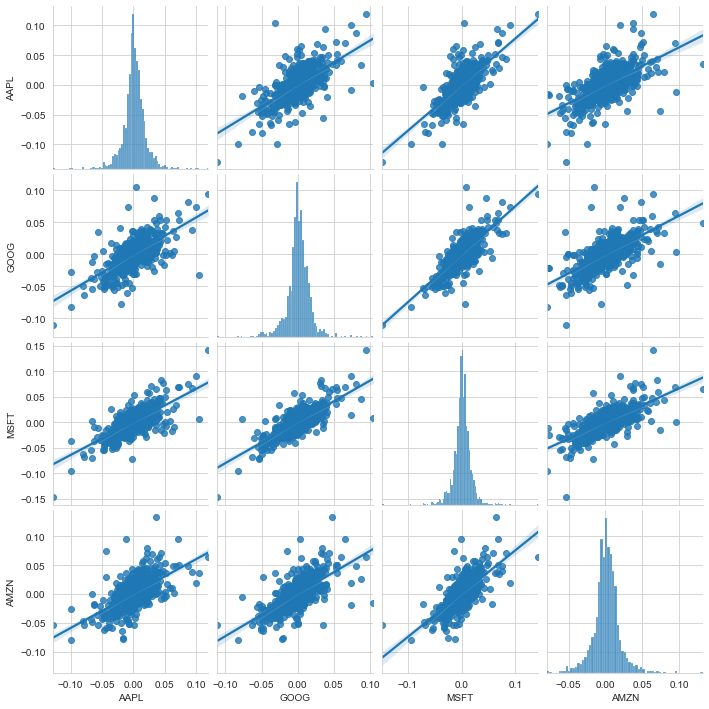

In [15]:
sns.set_style('whitegrid')
# sns.jointplot('GOOG', 'GOOG', df_compare_change, kind='scatter', color='seagreen')

sns.pairplot(df_compare_change, kind='reg')

Also, observing the correlations of stocks over the year could be a route map to have a guess of future of stocks.

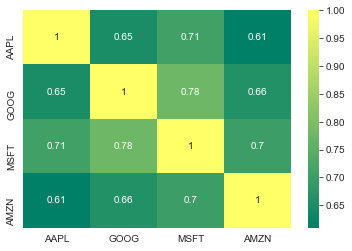

In [16]:
sns.heatmap(df_compare_change.corr(), annot=True, cmap='summer')

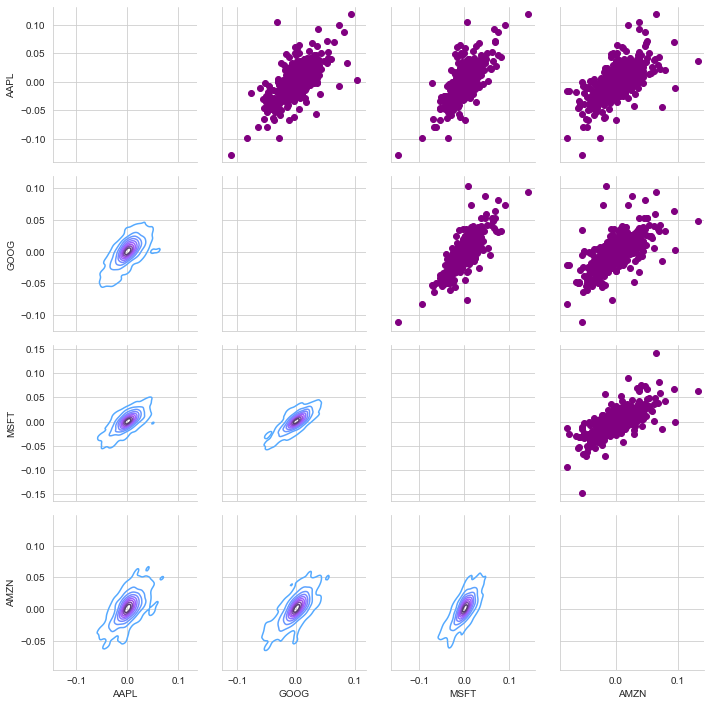

In [17]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(df_compare_change.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

Finally, what we want to do is using the time series of these stocks and predict their future. an dalso use close stocks in the area fo comapny predicts its future. 

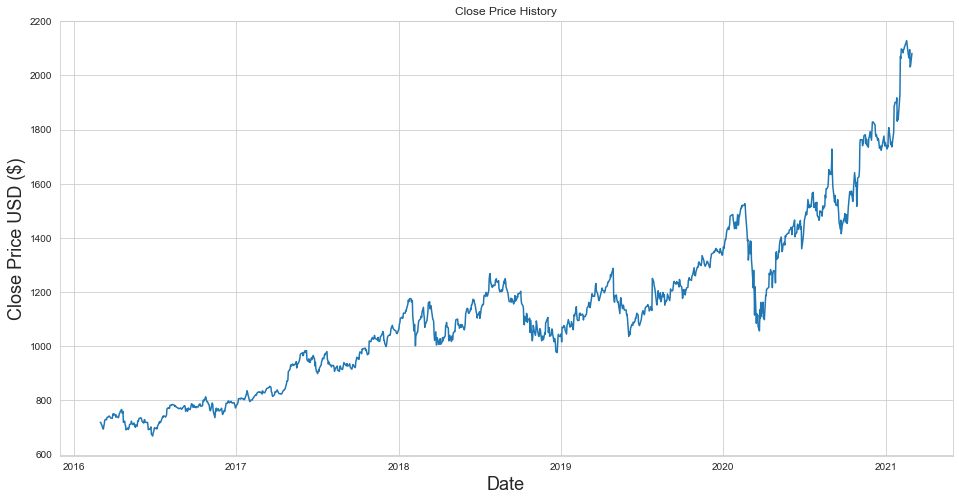

In [18]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(s_and_p_data[s_and_p_data.Name=='GOOG']['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In a cross platform Covid-19 data is accessible from John Hopkings CSSE.
The Covid data is also read and interaction between Covid data and stock data would be drawn.

In [20]:
# John Hobkins CSSE DATABASE in github updated daily for new cases
confirmed_cases_data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
death_cases_data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
# death_cases_data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
#convert data to pandas dataframes
raw_data_confirmed = pd.read_csv(confirmed_cases_data_url)
raw_data_death = pd.read_csv(death_cases_data_url)
# raw_data_recovered = pd.read_csv(recovery_cases_data_url)
# Grou pdata by states for confirmed cases
df_confirmed_states = raw_data_confirmed.groupby(['Province_State']).sum().drop(['Lat','Long_','UID','code3','FIPS'], axis = 1)
df_confirmed_states = df_confirmed_states.reset_index().melt(id_vars='Province_State', var_name='date')
df_confirmed_states['date'] = pd.to_datetime(df_confirmed_states['date'])
df_confirmed_states = df_confirmed_states.pivot(index='date', columns='Province_State', values='value').sort_values(by='date')#,ascending=False)
df_confirmed_states['US'] = df_confirmed_states.sum(axis=1)
# group data by states for death tolls
df_death_states = raw_data_death.groupby(['Province_State']).sum().drop(['Lat', 'Long_', 'UID', 'code3', 'Population', 'FIPS'], axis = 1)
df_death_states = df_death_states.reset_index().melt(id_vars='Province_State', var_name='date')
df_death_states['date'] = pd.to_datetime(df_death_states['date'])
df_death_states = df_death_states.pivot(index='date', columns='Province_State', values='value').sort_values(by='date')#,ascending=False)
df_death_states['US'] = df_death_states.sum(axis=1)

In [22]:
df_confirmed_states.head()

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming,US
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
2020-01-26,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5


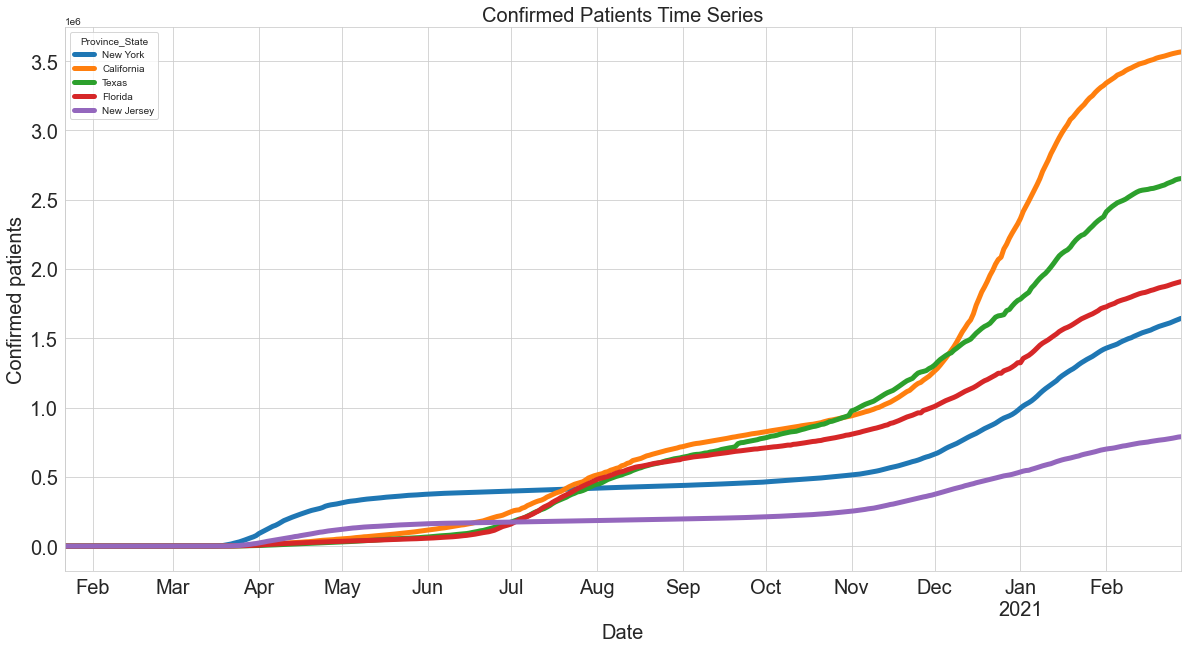

In [23]:
# Plot time series of several states of interest
selected_states = ['New York', 'California', 'Texas', 'Florida', 'New Jersey']
df_confirmed_states[selected_states].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Confirmed patients', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

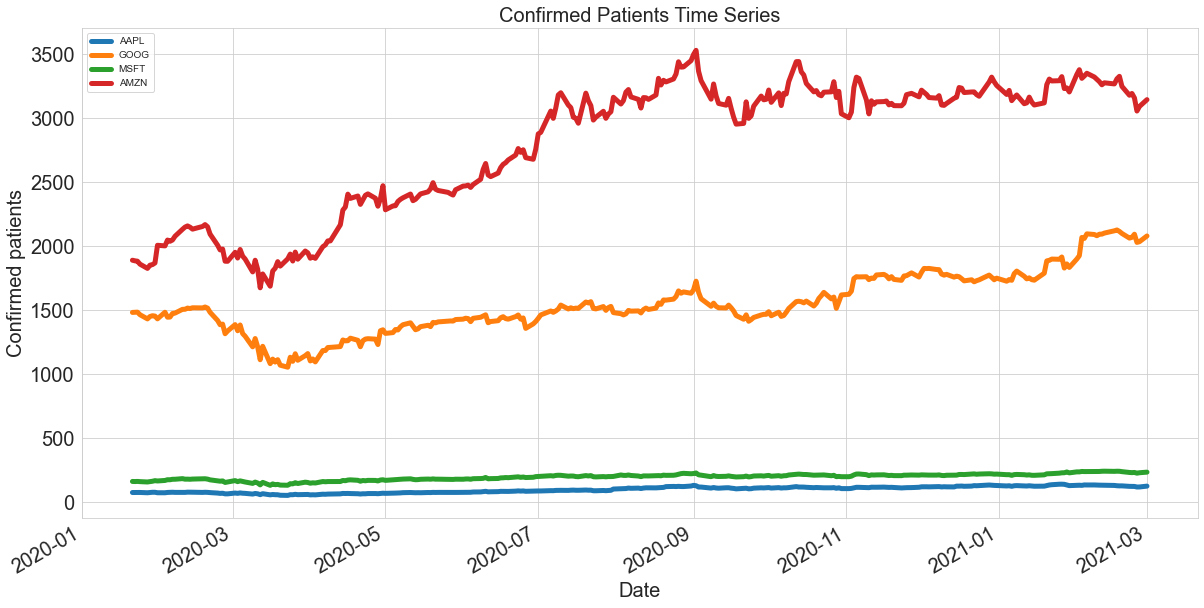

In [60]:
major_tech = ['AAPL', 'GOOG', 'MSFT', 'AMZN'] 
df_compare_covid = df_compare[(df_compare.index > datetime(2020,1,20)) & (df_compare.index < datetime.now())]
df_compare_covid.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Confirmed patients', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

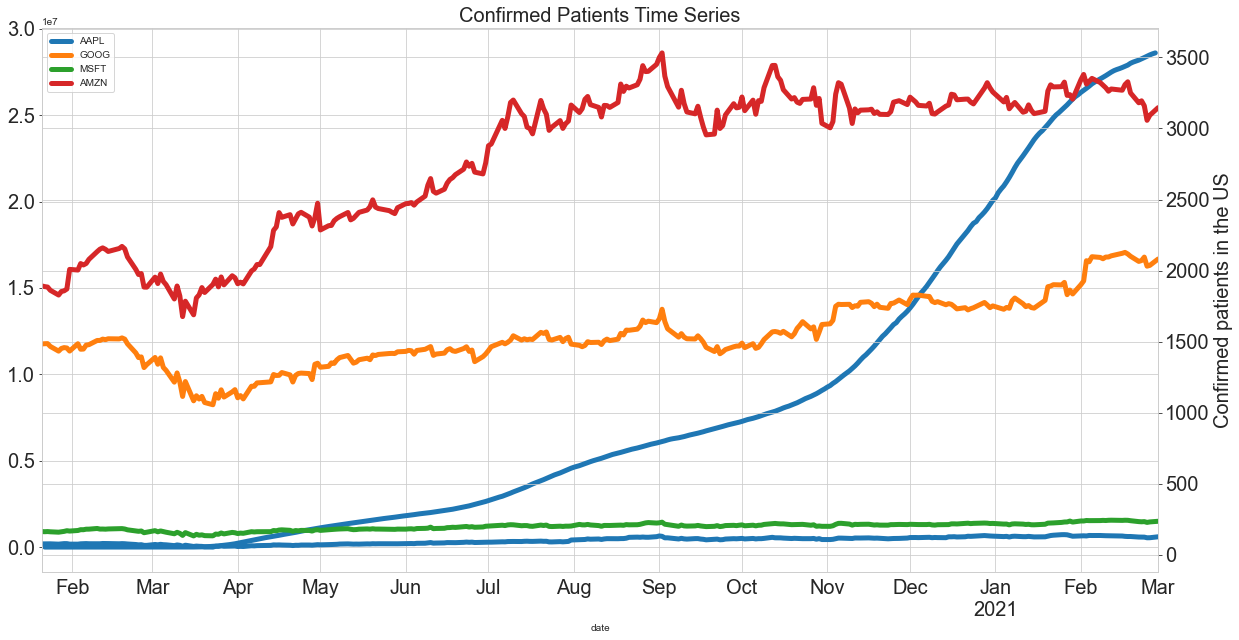

In [58]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# ax3 = ax.twinx()


df_confirmed_states["US"].plot(figsize=(20,10), linewidth=5, fontsize=20, ax=ax)
# df_death_states["US"].plot(figsize=(20,10), linewidth=5, fontsize=20, ax=ax, ls="--")
major_tech = ['AAPL', 'GOOG', 'MSFT', 'AMZN'] 
df_compare_covid = df_compare[df_compare.index > datetime(2020,1,20)]
df_compare_covid.plot(figsize=(20,10), linewidth=5, ax=ax2, fontsize=20)
# df_death_states["New York"].plot(figsize=(20,10), linewidth=5, fontsize=20, ax=ax2, ls="--")

plt.ylabel('Confirmed patients in the US', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

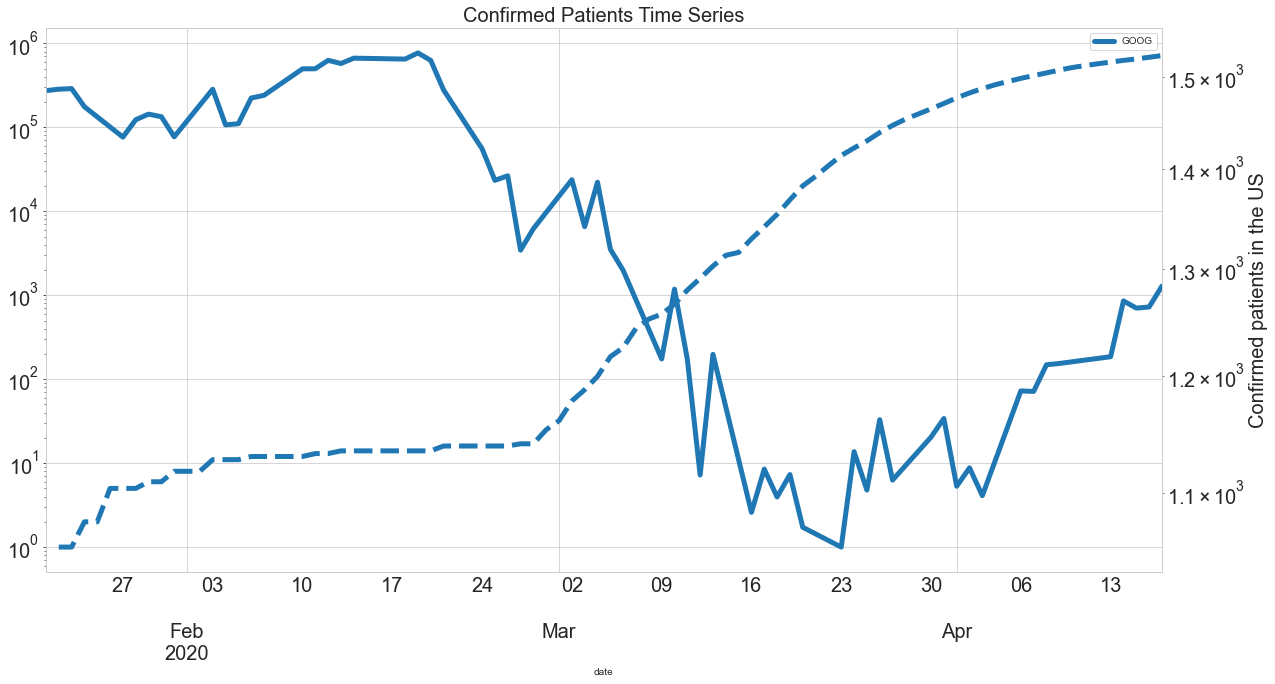

In [78]:
comparison = ['GOOG']

df_compare_covid_3 = df_compare[(df_compare.index > datetime(2020,1,20)) & (df_compare.index < datetime(2020,4,20))]
df_confirmed_states_3 = df_confirmed_states[(df_confirmed_states.index > datetime(2020,1,20)) & (df_confirmed_states.index < datetime(2020,4,20))]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_yscale('log')
ax.set_yscale('log')

df_confirmed_states_3["US"].plot(figsize=(20,10), linewidth=5, fontsize=20, ax=ax, ls="--")
df_compare_covid_3[comparison].plot(figsize=(20,10), linewidth=5, ax=ax2, fontsize=20)

plt.ylabel('Confirmed patients in the US', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

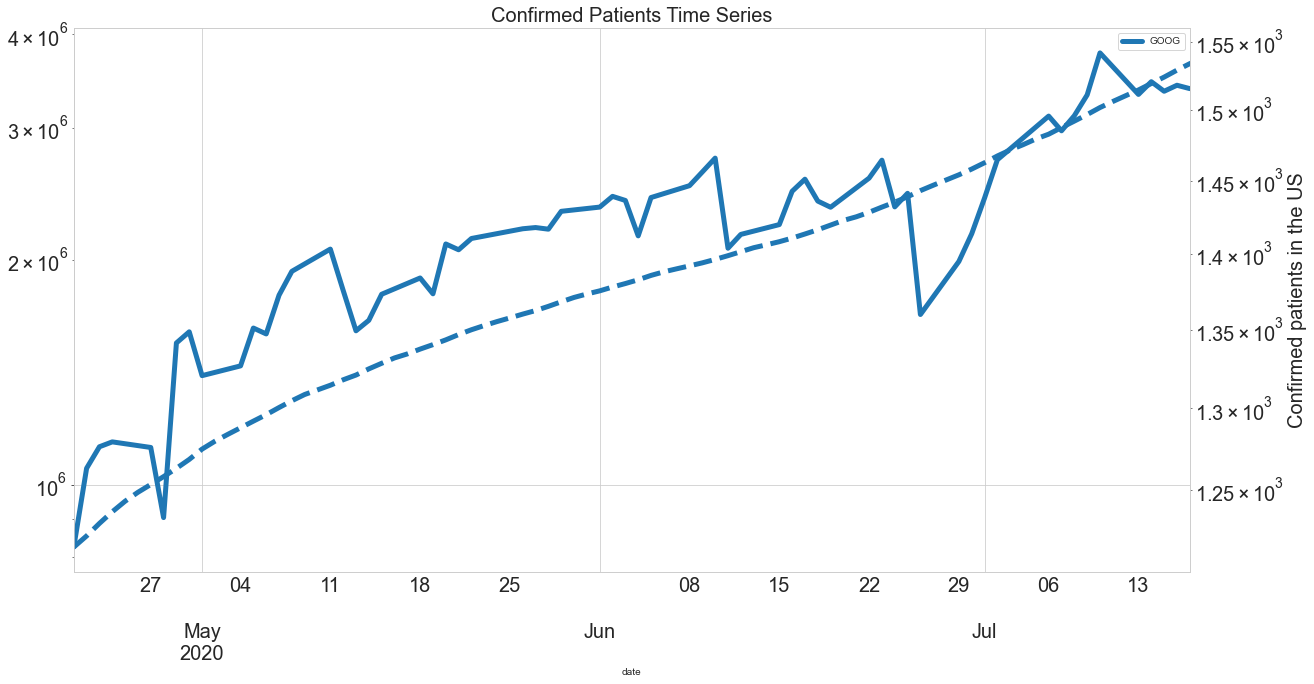

In [81]:
comparison = ['GOOG']

df_compare_covid_3 = df_compare[(df_compare.index > datetime(2020,4,20)) & (df_compare.index < datetime(2020,7,20))]
df_confirmed_states_3 = df_confirmed_states[(df_confirmed_states.index > datetime(2020,4,20)) & (df_confirmed_states.index < datetime(2020,7,20))]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_yscale('log')
ax.set_yscale('log')

df_confirmed_states_3["US"].plot(figsize=(20,10), linewidth=5, fontsize=20, ax=ax, ls="--")
df_compare_covid_3[comparison].plot(figsize=(20,10), linewidth=5, ax=ax2, fontsize=20)

plt.ylabel('Confirmed patients in the US', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

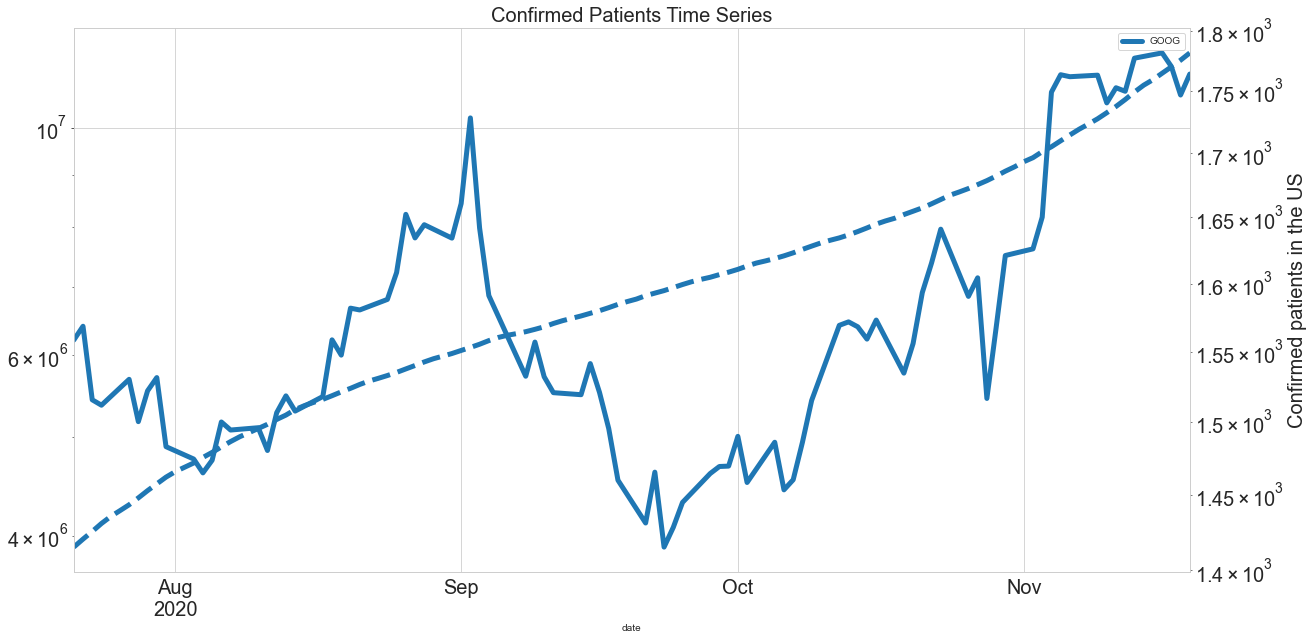

In [83]:
comparison = ['GOOG']

df_compare_covid_3 = df_compare[(df_compare.index > datetime(2020,7,20)) & (df_compare.index < datetime(2020,11,20))]
df_confirmed_states_3 = df_confirmed_states[(df_confirmed_states.index > datetime(2020,7,20)) & (df_confirmed_states.index < datetime(2020,11,20))]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_yscale('log')
ax.set_yscale('log')

df_confirmed_states_3["US"].plot(figsize=(20,10), linewidth=5, fontsize=20, ax=ax, ls="--")
df_compare_covid_3[comparison].plot(figsize=(20,10), linewidth=5, ax=ax2, fontsize=20)

plt.ylabel('Confirmed patients in the US', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

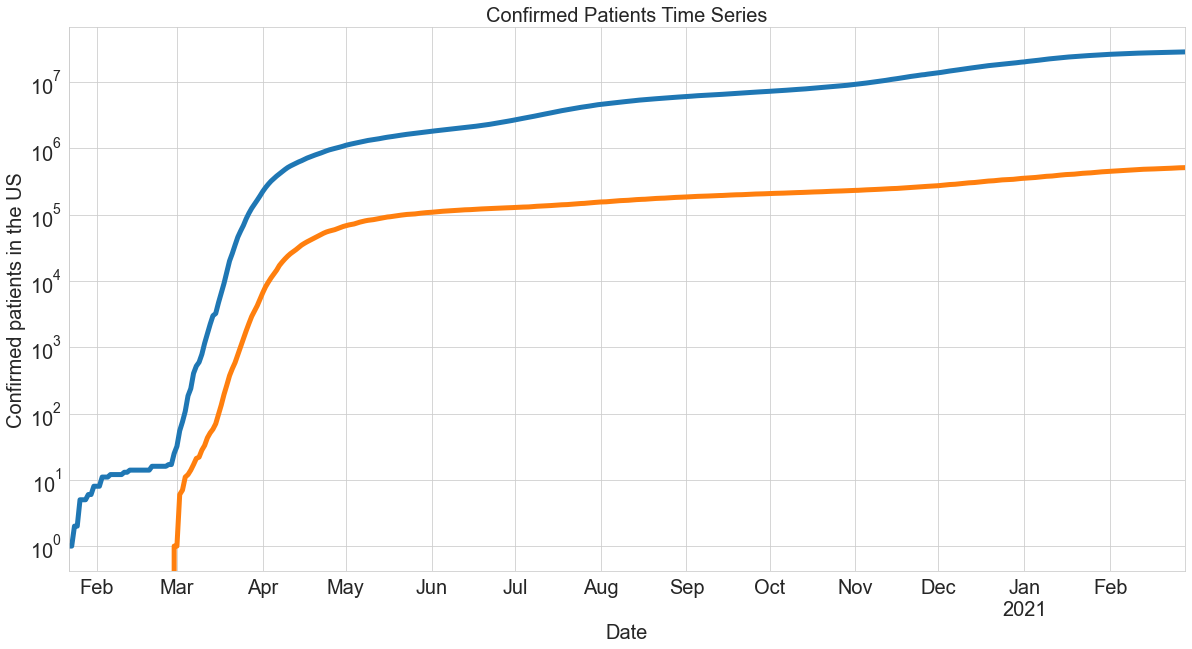

In [55]:
# Plot time series of several states of interest
df_confirmed_states['US'].plot(figsize=(20,10), linewidth=5, fontsize=20)
df_death_states['US'].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.yscale("log")
plt.ylabel('Confirmed patients in the US', fontsize=20);
plt.title('Confirmed Patients Time Series', fontsize=20);

In [ ]:
# Using plotly.express
import plotly.express as px

df = px.df_confirmed_states#[selected_states]
fig = px.line(df, x='date', y=selected_states)
fig.show()


In [ ]:
# Using graph_objects
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
fig.show()